## Подготовка данных

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.utils import shuffle

from sklearn.metrics import roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

In [108]:
data = pd.read_csv("Churn_Modelling.csv")

In [109]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


In [110]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [111]:
#Поля RowNumber, CustomerId, Surname можно удалить, их можно не учитывать при обучении модели
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [112]:
data['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [113]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [114]:
features = data.drop(['Exited'], axis=1)
target = data['Exited']

## Исследование задачи

### Признак Age категоральный преобразуем значение техникой OHE

In [115]:
features['Male'] = pd.get_dummies(features['Gender'], drop_first=True)
features = features.drop(['Gender'], axis=1)

### Признак Geography преобразуем техникой OrdinalEncoding

In [116]:
encoder = OrdinalEncoder()
geography = pd.DataFrame(encoder.fit_transform(features[['Geography']]),
                            columns=['Geography'], dtype=int)

In [117]:
features['Geography'] = geography

In [118]:
features.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Male
0,619,0,42,2,0.00,1,1,1,101348.88,0
1,608,2,41,1,83807.86,1,0,1,112542.58,0
2,502,0,42,8,159660.80,3,1,0,113931.57,0
3,699,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,43,2,125510.82,1,1,1,79084.10,0


### Разобъем данные на обучающую и валидационну и тестовую выборки

In [123]:
features, features_valid, target, target_valid = train_test_split(
    features, 
    target, 
    test_size = .20, 
    random_state=12345)


In [124]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size = .25,
    random_state=12345
)

In [125]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(4800, 10)
(4800,)
(1600, 10)
(1600,)
(1600, 10)
(1600,)


### Масштабируем признаки

In [126]:
pd.options.mode.chained_assignment = None
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']
scaler = StandardScaler()

scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Проверим адекватность модели

In [127]:
best_model = 0
max_depth = 0
for depth in range(1,20):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    
    if (best_model < accuracy):
        best_model = accuracy
        max_depth = depth

print('max depth:', max_depth, ': ', end='')
print(best_model)

max depth: 6 : 0.86


In [128]:
best_est = 0 
best_result = 0
for est in range(1,50):
    model = RandomForestClassifier(random_state=12345, 
                                   n_estimators = est, 
                                   max_depth=10, 
                                   class_weight='balanced')
    model.fit(features_train, target_train)
    #predict = model.predict(features_valid)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_est = est
        best_result = result

print('Est:', best_est, ': ', end='')
print(best_result)

Est: 26 : 0.8475


F1: 0.5702127659574467
Accuracy: 0.810625
AUC: 0.8498795137802138

0    0.74875
1    0.25125
dtype: float64


<AxesSubplot:>

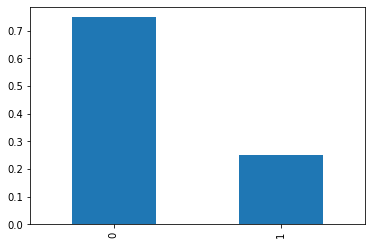

In [129]:
model = RandomForestClassifier(random_state=12345, 
                               n_estimators = 35, 
                               max_depth=7, 
                               class_weight='balanced')
model.fit(features_train, target_train)
predict = model.predict(features_valid)

print('F1:', f1_score(target_valid, predict))

accuracy_valid= accuracy_score(target_valid, predict)
print('Accuracy:',accuracy_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC:', auc_roc)

print()
predicted_valid = pd.Series(predict)
class_frequency = predicted_valid.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Чаще встречается целевой признак со значением 0

In [130]:
print(confusion_matrix(target_valid, predict))

[[1096  201]
 [ 102  201]]


- Модель чаще предсказывает отрицательные значения
- Почситаны значения AUC: 0.86, F1: 0.62, Accuracy: 0.81.


## Борьба с дисбалансом

In [131]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [132]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [133]:
#Обучим модель DecisionTreeClassifier
tree_model = DecisionTreeClassifier(random_state=12345, max_depth=7, class_weight='balanced')
tree_model.fit(features_upsampled, target_upsampled)
predict = tree_model.predict(features_valid)
print('F1:', f1_score(target_valid, predict))

accuracy_valid= accuracy_score(target_valid, predict)
print('Accuracy:',accuracy_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC:', auc_roc)

F1: 0.5389876880984952
Accuracy: 0.789375
AUC: 0.8498795137802138


In [134]:
#Обучим модель RandomForestClassifier
model = RandomForestClassifier(random_state=12345, 
                               n_estimators = 37, 
                               max_depth=10, 
                               class_weight='balanced')
model.fit(features_upsampled, target_upsampled)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

predict = model.predict(features_valid)

print('F1:', f1_score(target_valid, predict))

accuracy_valid= accuracy_score(target_valid, predict)
print('Accuracy:',accuracy_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC:', auc_roc)

F1: 0.578102189781022
Accuracy: 0.819375
AUC: 0.8439862490489604


## Тестирование модели

In [135]:
test_prediction = model.predict(features_test)
print('F1:', f1_score(target_test, test_prediction))

F1: 0.6051560379918589


In [136]:
result = model.score(features_test, target_test) 
print("Accuracy:", result)

Accuracy: 0.818125


AUC: 0.8439862490489604


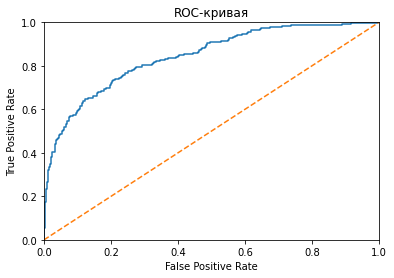

In [137]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC:',auc_roc)

plt.figure()

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

# Вывод

 - Наиболее лучшая модель RandomForestClassifier
 - на обучающей выборке достигнуты целевые показатели F1: 0.62, Accuracy: 0.8, AUC: 0.86 при значениях гиперпараметров n_estimators = 37, max_depth=10
 - на тестовой выборке значения показателей составили F1: 0.59, Accuracy: 0.8, AUC: 0.86